In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import resample
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None 

In [2]:
df = pd.read_csv(r'/Users/tsaichao-yi/Downloads/Parking_Violations_Issued_-_Fiscal_Year_2015.csv')  

/var/folders/6d/_t56tgqs5rb4zjpyv64nnjvc0000gn/T/ipykernel_4012/442458610.py:1: DtypeWarning: Columns (18,29,38,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'/Users/tsaichao-yi/Downloads/Parking_Violations_Issued_-_Fiscal_Year_2015.csv')


The first step is removing variables with more than 30% missing values since any imputation method could not provide a reliable result.

In [3]:
def missing(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
    return missing_value_df
lost = missing(df)['percent_missing'] > 0.3
df1 = df[df.columns[~lost]]

Here, I deleted several noninformative variables and extracted the partitions of attributes as the new ones, including 'Issue Year', 'Issue Day', 'Vehicle Expiration Year', 'Violation Hour', and 'Violation Minute'. Then, I replaced the outliers in features with null values. These will be imputed later.  

In [4]:
pre_hour = [str(w)[:2] for w in list(df1['Violation Time']) ]
df1['Violation Hour'] =  pd.Series([(int(w) if 0<=int(w)<=24 else np.NaN) if w.isdigit() else np.NaN for w in pre_hour])
pre_minute = [str(w)[2:4] for w in list(df1['Violation Time']) ]
df1['Violation Minute'] = pd.Series([(int(w) if 0<=int(w)<=60 else np.NaN) if w.isdigit() else np.NaN for w in pre_minute])
df1['Issue Day'] = pd.Series([int(w[:2]) for w in list(df1['Issue Date'])])
df1['Issue Year'] = pd.Series([int(w[-4:]) for w in list(df1['Issue Date'])])
df1['Vehicle Expiration Year'] = pd.Series([int(w[6:10]) for w in list(df1['Vehicle Expiration Date'])])
df1.replace({'Vehicle Expiration Year' : { 8888 :  np.NaN, 1:np.NaN}}, inplace = True)
df1.replace({'Vehicle Year': {0 : np.NaN}}, inplace = True)
df1.drop(['Summons Number', 'Plate ID', 'Date First Observed', 'Violation Time', 'Issue Date', 'Vehicle Expiration Date'], 
         axis=1, inplace = True)

The following list indicates the number of unique classes in each categorical variable. Due to the vast number of observations, most of them would be converted to dummy variables using the label encoding.

In [5]:
for i in df1.columns:
    print(i, len(df1[i].unique()))

Registration State 69
Plate Type 88
Violation Code 100
Issuing Agency 19
Street Code1 6466
Street Code2 6834
Street Code3 6707
Violation Precinct 525
Issuer Precinct 731
Issuer Code 38789
Street Name 110543
Law Section 5
Sub Division 141
Vehicle Year 100
Feet From Curb 18
Violation Hour 24
Violation Minute 61
Issue Day 12
Issue Year 20
Vehicle Expiration Year 68


Categorical variables, such as ' Plate Type', 'Street Name', and 'Sub Division' were converted using label encoding. In contrast, variables' Registration State', 'Issuing Agency', and 'Law Section' was converted using one-hot encoding. The decision to use one-hot encoding or label encoding depends on the characteristics of the variables. For instance, if one attribute has hundreds of classes, it is better to use the latter even if the relationship between each class is not ordinal, as the data dimension would explode if the one-hot encoding is picked.

In [6]:
df1['Plate Type'] = df1['Plate Type'].astype('category')
df1['Plate Type'] = df1['Plate Type'].cat.codes
df1['Street Name'] = df1['Street Name'].astype('category')
df1['Street Name'] = df1['Street Name'].cat.codes
df1['Sub Division'] = df1['Sub Division'].astype('category')
df1['Sub Division'] = df1['Sub Division'].cat.codes
dum_df = pd.get_dummies(df1, columns=['Registration State'], prefix=['State'])
dum_df = pd.get_dummies(dum_df, columns=['Issuing Agency'], prefix=['Agency'])
dum_df = pd.get_dummies(dum_df, columns=['Law Section'], prefix=['Law Section'])

Since PySpark does not allow a dot in the feature name, I renamed the columns that initially had dots in their name.

In [7]:
dum_df = dum_df.rename({'Law Section_0.0': 'Law Section_0'}, axis=1)
dum_df = dum_df.rename({'Law Section_408.0': 'Law Section_408'}, axis=1)
dum_df = dum_df.rename({'Law Section_1111.0': 'Law Section_1111'}, axis=1)
dum_df = dum_df.rename({'Law Section_1180.0': 'Law Section_1180'}, axis=1)
dum_df = dum_df.rename({'Plate Type': 'label'}, axis=1)

Here, I split 80% of the data into the training data set and the rest of the testing data.

In [8]:
cont_feats = [col for col in dum_df.columns if col != 'label']
X_train, X_test, y_train, y_test = train_test_split(
     dum_df[cont_feats], dum_df['label'], test_size=0.2, random_state=0)
new = X_train.join(y_train)

Since we can see from the following table that most plate type is Passenger Vehicles (PAS), accounting for more than 70% of the data, we need to balance the outcome attribute. Due to the size of the data, I decided to use the downsampling technique to reduce the number of observations. After making the data balanced, the number of observations decreases to about 5.2 million. 

In [9]:
df1['Plate Type'].value_counts(normalize=True).reset_index(name='%').head(10) 

,index,%
0,61,0.723932
1,18,0.197150
2,56,0.028751
3,73,0.010980
4,55,0.008332
5,0,0.005597
6,31,0.005236
7,81,0.002491
8,46,0.002350
9,54,0.001907


In [10]:
most = new[new['label']== 61]
less = new[new['label']!= 61]
most_downsample = resample(most, replace=True, n_samples=len(less), random_state=0)
downsampled = pd.concat([most_downsample, less])

To tackle the missing values, I picked the multivariate feature imputation approach in the package scikit-learn. Instead of imputing the mean or median of the column to the missing values, this method can avoid increasing the correlation between the values in each column. Moreover, I set the minimum and maximum possible imputed values from each feature to prevent imputing weird values.

In [11]:
downsampled.replace({'Sub Division': {-1 : np.NaN}}, inplace = True)
downsampled.replace({'Street Name': {-1 : np.NaN}}, inplace = True)
iter_imputer = IterativeImputer(random_state=0, min_value=[1970, 1971, 0, 1, 1985,0, 0,
                                                        0, 0, 0, 0, 0, 0, 1, 0, 24], 
                                max_value=[2069, 2066, 16, 12, 2015, 98260, 98310,
                                          98280, 994,99, 996, 999992, 139,110540, 24, 60])
feats = ['Vehicle Year', 'Vehicle Expiration Year', 'Feet From Curb', 'Issue Day', 'Issue Year',
        'Street Code1', 'Street Code2', 'Street Code3', 'Violation Precinct',
         'Violation Code', 'Issuer Precinct','Issuer Code', 'Sub Division', 'Street Name', 'Violation Hour', 'Violation Minute']
iter_imputed = iter_imputer.fit_transform(downsampled[feats])
df_iter_imputed = pd.DataFrame(iter_imputed, columns=feats)
df_iter_imputed.reset_index(inplace=True, drop=True)
downsampled.reset_index(inplace=True, drop=True)
impute = pd.concat([df_iter_imputed, downsampled[downsampled.columns.difference(feats)]], axis=1)

Next, I utilized a feature selector to discard all low-variance features. As most features are not on the same scale, I normalized them first and set the threshold to 0.003.

In [12]:
selector = VarianceThreshold(threshold=.003)
normalized_df = impute / impute.mean()
_ = selector.fit(normalized_df)
mask = selector.get_support()
df_select = impute.loc[:, mask]

/Users/tsaichao-yi/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


Because we would use logistic regression for prediction, we should hamper the multicollinearity problem by filtering highly correlated predictors within the training data set. I removed variables 'Sub Division' and 'Issuer Code'. 

In [13]:
threshold = 0.75
def high_cor_function(df):
    cor = df.corr()
    corrm = np.corrcoef(df.transpose())
    corr = corrm - np.diagflat(corrm.diagonal())
    print('max corr:',corr.max(), ', min corr: ', corr.min())
    c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
    high_cor = c1[c1.values!=1]    
    thresh = threshold 
    display(high_cor[high_cor>thresh])
high_cor_function(df_select)

max corr: 0.8839652440974837 , min corr:  -0.9999924549884882


Agency_T  Sub Division    0.883965
Agency_P  Issuer Code     0.767297
dtype: float64

I also did the same imputation scheme on the testing data set, so there are no missing values. The final step was to delete features that did not appear in the training data set.

In [14]:
df_select.drop(['Sub Division', 'Issuer Code'], axis=1, inplace = True)
new_test = X_test.join(y_test)
new_test.replace({'Sub Division': {-1 : np.NaN}}, inplace = True)
new_test.replace({'Street Name': {-1 : np.NaN}}, inplace = True)
iter_imputed = iter_imputer.fit_transform(new_test[feats])
df_iter_imputed = pd.DataFrame(iter_imputed, columns=feats)
df_iter_imputed.reset_index(inplace=True, drop=True)
new_test.reset_index(inplace=True, drop=True)
impute = pd.concat([df_iter_imputed, new_test[new_test.columns.difference(feats)]], axis=1)
test = impute[df_select.columns]

In [15]:
test.to_csv(r'/Users/tsaichao-yi/Desktop/test.csv',index=False)
df_select.to_csv(r'/Users/tsaichao-yi/Desktop/train.csv',index=False)

We have completed the data preprocessing steps. Now, instead of converting Pandas data frame to PySpark data frame using the function spark.createDataFrame(), I chose to save the files first and then import them as the PySpark data frame, as this takes less time.

In [16]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, \
NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
spark = SparkSession.builder \
.appName('app_name') \
.master('local[*]') \
.config('spark.sql.execution.arrow.pyspark.enabled', True) \
.config('spark.sql.session.timeZone', 'UTC') \
.config('spark.driver.memory','32G') \
.config('spark.ui.showConsoleProgress', True) \
.config('spark.sql.repl.eagerEval.enabled', True) \
.getOrCreate()
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction") 

22/10/11 20:42:37 WARN Utils: Your hostname, TSAIdeMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.19.93.159 instead (on interface en0)
22/10/11 20:42:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/10/11 20:42:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [18]:
test_spark = spark.read.option('inferSchema',True) \
        .option('header', 'true') \
  .csv(r'/Users/tsaichao-yi/Desktop/test.csv')
train_spark = spark.read.option('inferSchema',True) \
        .option('header', 'true') \
  .csv(r'/Users/tsaichao-yi/Desktop/train.csv')

I only aggregated all the covariates in the feature column using VectorAssembler, as other data preprocessing procedures were completed using the Pandas package. This is why there is only one element in the Pipeline list.

In [19]:
Cols = [col for col in train_spark.columns if col != 'label']
stage1 = VectorAssembler(inputCols=Cols, outputCol= 'features')
pipeline = Pipeline(stages=[stage1])
train = pipeline.fit(train_spark).transform(train_spark)
test = pipeline.fit(test_spark).transform(test_spark)

Since the data set is large, it is time-consuming to run a 10-fold cross-validation. Hence, only 5-fold was used here. The maximum number of bins for discretizing continuous features and the number of trees to train are two hyperparameters to tune in random forest.

In [20]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed = 0)
paramGrid= (ParamGridBuilder()
           .addGrid(rf.maxBins, [26, 28])
           .addGrid(rf.numTrees, [7, 9])
           .build())
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, 
                   evaluator=evaluator, numFolds=5)
cvModel1 = cv.fit(train)
pred1 = cvModel1.transform(test)

22/10/11 20:45:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


The only hyperparameter I tune in logistic regression is the elasticNet mixing parameter.

In [21]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', family='multinomial')
paramGrid = (ParamGridBuilder()
           .addGrid(lr.elasticNetParam, [0.1, 0.2, 0.3])
           .build())
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                   evaluator=evaluator, numFolds=5)
cvModel2 = cv.fit(train)
pred2 = cvModel2.transform(test)

22/10/11 21:29:09 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/10/11 21:29:09 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


The maximum number of bins for discretizing continuous features for the decision tree is the only hyperparameter to tune. 

In [22]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', seed = 0)
paramGrid= (ParamGridBuilder()
            .addGrid(dt.maxBins, [30, 31, 32, 33])
           .build())
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, 
                   evaluator=evaluator, numFolds=5)
cvModel3 = cv.fit(train)
pred3 = cvModel3.transform(test) 

I only tune the smoothing parameter in the Naive Bayes method.

In [23]:
nb = NaiveBayes(featuresCol = 'features', labelCol = 'label', modelType='multinomial')
paramGrid= (ParamGridBuilder()
           .addGrid(nb.smoothing, [2030, 2035, 2040])
           .build())
cv = CrossValidator(estimator=nb, estimatorParamMaps=paramGrid, 
                   evaluator=evaluator, numFolds=5)
cvModel4 = cv.fit(train)
pred4 = cvModel4.transform(test)

The usage of the following functions and class is to assist in searching for the best model and its parameters setting.

In [24]:
#https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
def detail(pred):
    preds = pred.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
    points = CurveMetrics(preds).get_curve('roc')
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    return x_val, y_val
def integrate(x, y):
   sm = 0
   for i in range(1, len(x)):
       h = x[i] - x[i-1]
       sm += h * (y[i-1] + y[i]) / 2
   return sm
def acc(forecast):
    return evaluator.evaluate(forecast)

In [25]:
d1 = detail(pred1)
d2 = detail(pred2)
d3 = detail(pred3)
d4 = detail(pred4)

The following ROC curves show that all approaches have above-average performance, except for the Naive Bayes method. We can confirm which is better from the following table by calculating the area under the curve (AUC).

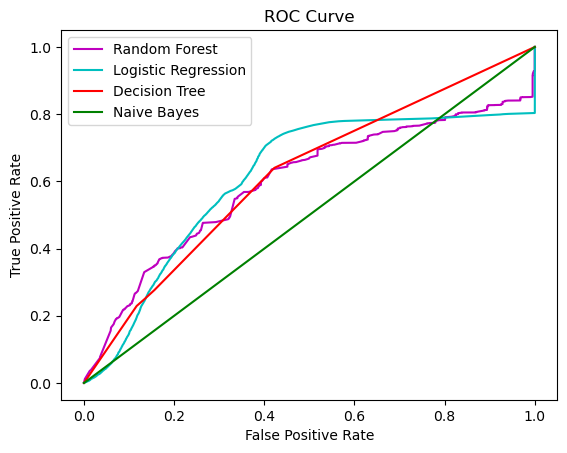

In [26]:
plt.title('ROC Curve')
plt.plot(d1[0], d1[1], color = 'm', label = 'Random Forest')
plt.plot(d2[0], d2[1], color = 'c', label = 'Logistic Regression')
plt.plot(d3[0], d3[1], color = 'r', label = 'Decision Tree')
plt.plot(d4[0], d4[1], color = 'g', label = 'Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

The table below indicates that the decision tree has the highest accuracy and the largest AUC, reaching 0.75 and 0.62, respectively. The random forest is also a competitive candidate. Generally speaking, except for the Naive Bayes, all models perform well-considering accuracy since their values are above 0.7. The probable reason why Naive Bayes has a poor forecast capability is that it assumes each feature makes an independent and equal contribution to the outcome. However, this condition is not met in our case, as some attributes may be more prominent than others. The tree-based methods work well because, from my guessing, I did not normalize the variables before training, and these methods can tolerate the considerable difference between the scale of variables.

In [27]:
accuracy = pd.DataFrame({
  'Models': ['Random Forest', 'Logistic Regression', 'Decision Tree', 'Naive Bayes'],
  'Accuracy': [acc(pred1), acc(pred2), acc(pred3), acc(pred4)],
  'Area Under ROC': [integrate(d1[0], d1[1]), integrate(d2[0], d2[1]), 
                     integrate(d3[0], d3[1]), integrate(d4[0], d4[1])]
})
accuracy

,Models,Accuracy,Area Under ROC
0,Random Forest,0.749676,0.594742
1,Logistic Regression,0.701631,0.608736
2,Decision Tree,0.752759,0.618932
3,Naive Bayes,0.001085,0.499824


For the best model, the maximum number of bins for discretizing continuous features should be 30.

In [28]:
cvModel3.bestModel._java_obj.getMaxBins()

30